In [12]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

## Part b

In [13]:
epsilon = 0.2
mu = 0.1
delta_x = 0.4
delta_t = 0.1
N_x = 130
L = N_x*delta_x
print(L)

52.0


In [14]:
x = np.linspace(0,L,N_x)
u_0 = np.zeros(N_x)
for j in range(len(u_0)):
    u_0[j] = 0.5*(1-np.tanh((x[j]-25)/5))

Text(0.5, 1.0, 'Initial condition for Problem 3b)')

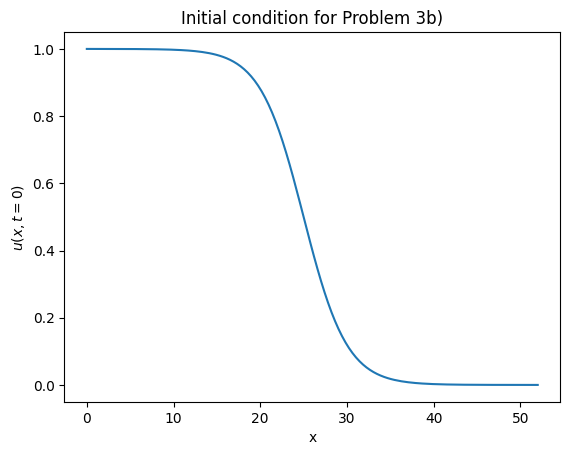

In [15]:
plt.plot(x, u_0)
plt.xlabel("x")
plt.ylabel("$u(x, t=0)$")
plt.title("Initial condition for Problem 3b)")

In [16]:
#Checking the stability condition:
s_fulfilled = True
for j in range(len(u_0)):
    s = (delta_t/delta_x)*(epsilon*np.abs(u_0[j])+4*(mu/(delta_x**2)))
    if s > 1:
        s_fulfilled = False
print("Stability criterion fulfilled: ", s_fulfilled)

Stability criterion fulfilled:  True


In [17]:
def apply_boundary_conditions(arr, arrs_prev, u_start, isfirst=False):
    """
    :param arr: array that boundary conditions are applied on
    :param arrs_prev: array before the current array and the array before that in case of isfirst=False ([u_current, u_prev])
    :param u_start: starting sequence of excursion values, the boundary values are constant for all times
    :param isfirst: True if we apply boundary conditions to the first simulation step
    :return: arr_final: The array with boundary conditions
    """
    if isfirst:
        arrs_prev = arrs_prev[np.newaxis, :]
    arr[0] = u_start[0]
    arr[-1] = u_start[-1]
    a = arrs_prev[1][-2] if not isfirst else arrs_prev[0][-2]
    b = arrs_prev[1][1] if not isfirst else arrs_prev[0][1]
    pref = 1 if not isfirst else 0.5
    arr[-2] = a - pref*(epsilon*delta_t/(3*delta_x))*(arrs_prev[0][-1]+arrs_prev[0][-2]+arrs_prev[0][-3])*(arrs_prev[0][-1]-arrs_prev[0][-3]) - pref*(mu*delta_t/(delta_x**3))*(-arrs_prev[0][-1]+2*arrs_prev[0][-3]-arrs_prev[0][-4])
    arr[1] = b - pref*(epsilon*delta_t/(3*delta_x))*(arrs_prev[0][2]+arrs_prev[0][1]+arrs_prev[0][0])*(arrs_prev[0][2]-arrs_prev[0][0]) - pref*(mu*delta_t/(delta_x**3))*(arrs_prev[0][3]+arrs_prev[0][0]-2*arrs_prev[0][2])
    arr_final = arr
    return arr_final

def KdV_first(u_start): 
    """
    Simulating the first time step in the Koorteweg-de Vries algorithm
    :param u_start: Initial sequence of excursion values
    :return u_1: First simulated sequence of temperature values
    """
    u_1 = np.zeros(N_x)
    u_1 = apply_boundary_conditions(u_1, u_start, u_start, isfirst=True)
    for j in range(2, N_x-2):
        u_1[j] = u_start[j] - (epsilon/6) * (delta_t/delta_x)*(u_start[j+1]+u_start[j]+u_start[j-1])*(u_start[j+1]-u_start[j-1]) - mu * (delta_t/(delta_x**3))*(u_start[j+2]+2*u_start[j-1]-2*u_start[j+1]-u_start[j-2])
    return u_1

def Koorteweg_de_Vries(num_timesteps, u_start): 
    """
    Algorithm to simulate the time evolution of a metallic rod in some reservoir
    :param num_timesteps: Number of total simulation time steps
    :param u_start: Initial sequence of temperature values
    :return u: array containing all temperature sequences for the num_timesteps time steps
    """
    # Simulating the first time step
    u_1 = KdV_first(u_start)
    u = [u_start, u_1]
    # Simulating the other time steps
    for t in tqdm(range(num_timesteps-1)):
        u_prev = u[-2] #n-1
        u_current = u[-1] #n
        u_next = np.zeros(N_x) #n+1
        u_next = apply_boundary_conditions(u_next, [u_current, u_prev], u_start)
        # Update values for the interior points
        for j in range(2,N_x-2):
            u_next[j] = u_prev[j] - ((epsilon*delta_t)/(3*delta_x))*(u_current[j+1]+u_current[j]+u_current[j-1])*(u_current[j+1]-u_current[j-1]) - mu*(delta_t/(delta_x**3))*(u_current[j+2]+2*u_current[j-1]-2*u_current[j+1]-u_current[j-2])
        # Check for NaN or Inf values in u_next
        if np.isnan(u_next).any() or np.isinf(u_next).any():
            print(f"NaN or Inf detected. Stopping simulation at timestep {t}.")
            break
        u.append(u_next)
    return u

In [18]:
u_KdV = Koorteweg_de_Vries(2000, u_0)

100%|██████████| 1999/1999 [00:00<00:00, 3095.35it/s]


Text(0.5, 1.0, '')

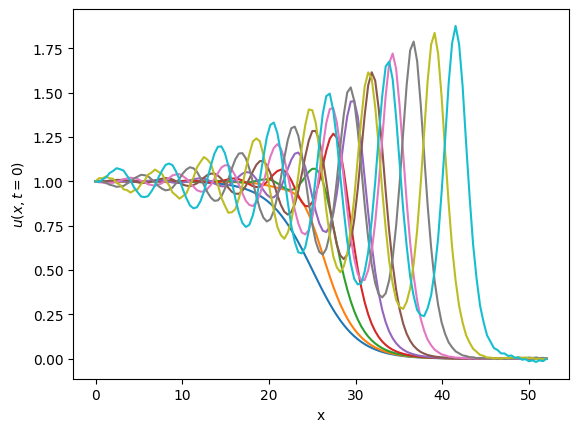

In [9]:
for t in range(10):
    plt.plot(x, u_KdV[t*200], label = f"t = {t*200}")
plt.xlabel("x")
plt.ylabel("$u(x, t=0)$")
plt.title("Time evolution of a single Soliton")

Text(0.5, 0.92, 'Time evolution of a single soliton')

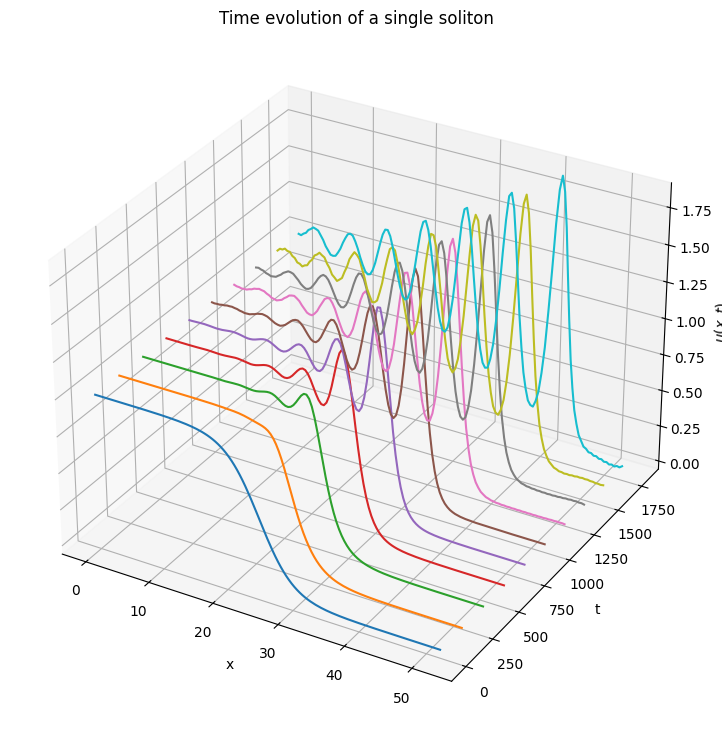

In [10]:
fig = plt.figure(figsize=(10,9))
ax = fig.add_subplot(projection='3d')
for t in range(10):
    ax.plot(x, t*200*np.ones(len(x)), u_KdV[t*200])
ax.set_xlabel('x')
ax.set_ylabel('t')
ax.set_zlabel('$u(x,t)$')
plt.title('Time evolution of a single soliton')

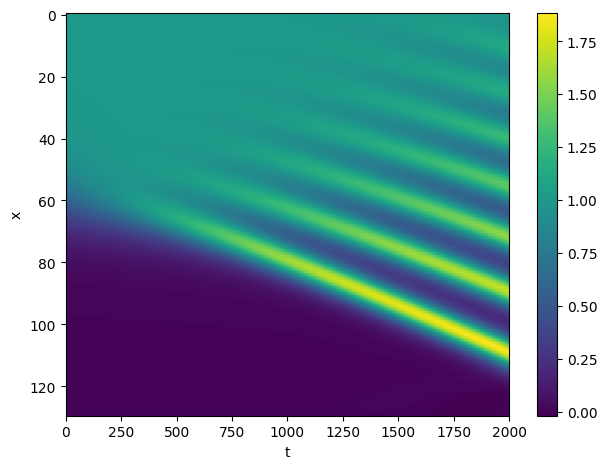

In [41]:
fig_1, ax_1 = plt.subplots()
u_KdV_transposed = np.transpose(np.array(u_KdV))
im = ax_1.imshow(u_KdV_transposed, aspect="auto")
cbar = fig_1.colorbar(im, ax=ax_1)
plt.xlabel("t")
plt.ylabel("x")
plt.tight_layout()
plt.show()

After 2000 simulation steps, the original soliton has evolved into 7 waves. From the 2D plot we can observe that the amplitudes of the waves (depicted by the yellow color) move in x direction with different velocities. This can be seen by the slope of the yellow lines, which is different and higher for the waves that arise earlier in time. Therefore, the observation of Scott Russell can be confirmed.

# Part c

In [9]:
u_0_new = np.zeros(N_x)
for j in range(len(u_0)):
    u_0_new[j] = 0.8*(1-np.tanh((3*j/12)-3)**2)+0.3*(1-np.tanh((4.5*j/26)-4.5)**2)

In [10]:
s_fulfilled = True
for j in range(len(u_0)):
    s = (delta_t/delta_x)*(epsilon*np.abs(u_0_new[j])+4*(mu/(delta_x**2)))
    if s > 1:
        s_fulfilled = False
print("Stability criterion fulfilled: ", s_fulfilled)

Stability criterion fulfilled:  True


Text(0.5, 1.0, 'Initial condition for Problem 3b)')

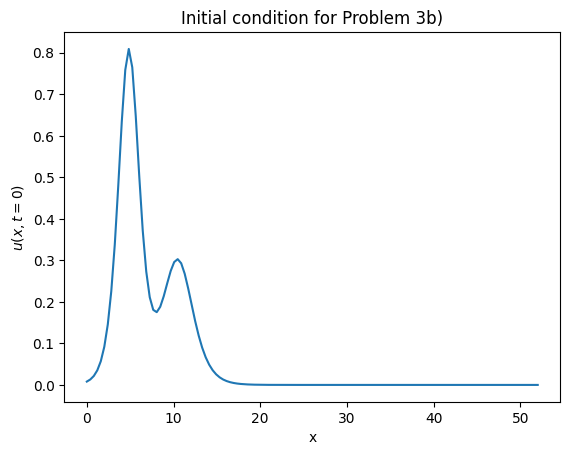

In [12]:
plt.plot(x, u_0_new)
plt.xlabel("x")
plt.ylabel("$u(x, t=0)$")
plt.title("Initial condition for Problem 3b)")

In [13]:
u_KdV_c = Koorteweg_de_Vries(2000, u_0_new)

100%|██████████| 1999/1999 [00:00<00:00, 5885.21it/s]


Text(0.5, 0.92, 'Time evolution of two solitons')

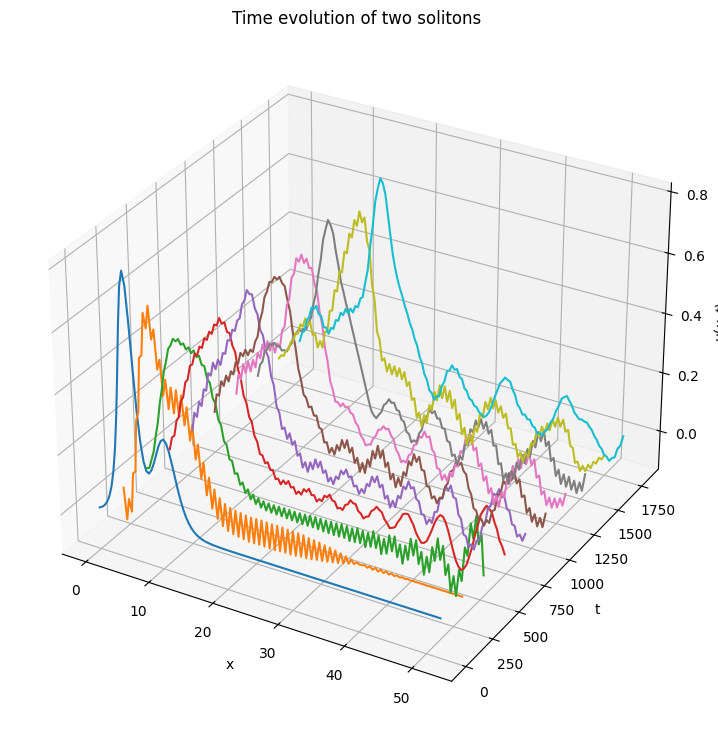

In [14]:
fig = plt.figure(figsize=(10,9))
ax = fig.add_subplot(projection='3d')
#for t in range(2000):
 #   ax.plot(x, t*np.ones(len(x)), u_KdV[t])
for t in range(10):
    ax.plot(x, t*200*np.ones(len(x)), u_KdV_c[t*200])
ax.set_xlabel('x')
ax.set_ylabel('t')
ax.set_zlabel('$u(x,t)$')
plt.title('Time evolution of two solitons')

Explore what happens when a tall soliton collides with a short one. Do they bounce off each other? Do they go through each other? Do they interfere? Do they destroy
each other? Does the tall soliton still move faster than the short one after collision?

When a tall soliton collides with a short one, they seem to unite into one wider soliton, which then creates smaller waves in the neighborhood.